In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
import ipdb
from sklearn.isotonic import IsotonicRegression
import seaborn as sns
from scipy.stats import binom, norm

from protein_conformal.util import *
data = np.load('/home/seyonec/protein-conformal/scope/foldseek_near_ids_scope_test_v_lookup.npy', allow_pickle=True)

print(len(data)) # for the scope 208 top k Foldseek alignment, 39 of the 400 queries have no hits in the dataset, so we filtered them out.
print(len(data[0]['S_i']))

/home/seyonec/.conda/envs/clean/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


361
14777


In [4]:
# filter all hits < -5 for Foldseek sims
# make sure min element in query['S_i'] to 0

for query in data:
    # set all elements < 0 to 0
    query['S_i'][query['S_i'] < 0] = 0

sims = np.stack([query['S_i'] for query in data], axis=0)
sims_flattened = sims.flatten()[sims.flatten() > -5]

# drop all negative one's from the Foldseek sims
sims_flattened = sims_flattened[sims_flattened != -1]

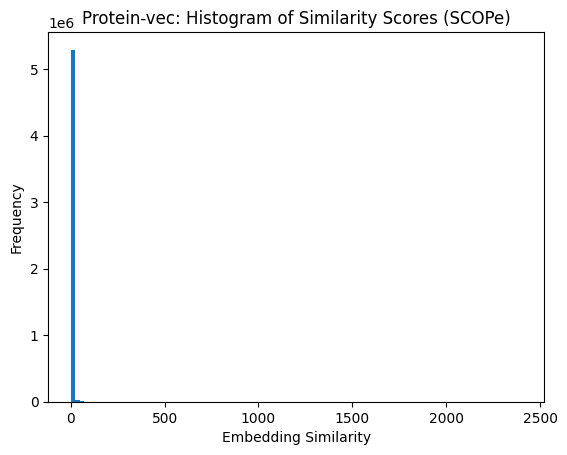

In [7]:
plt.hist(sims_flattened, bins=100)
plt.xlabel('Embedding Similarity')
plt.ylabel('Frequency')
plt.title('Protein-vec: Histogram of Similarity Scores (SCOPe)')
plt.show()

In [8]:
sims.max()

2401

In [9]:
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['exact'] for query in data], axis=0)
sims = np.stack([query['S_i'] for query in data], axis=0)

lambdas = np.linspace(0,sims.max(),1000) # set min to 0 for clarity
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]

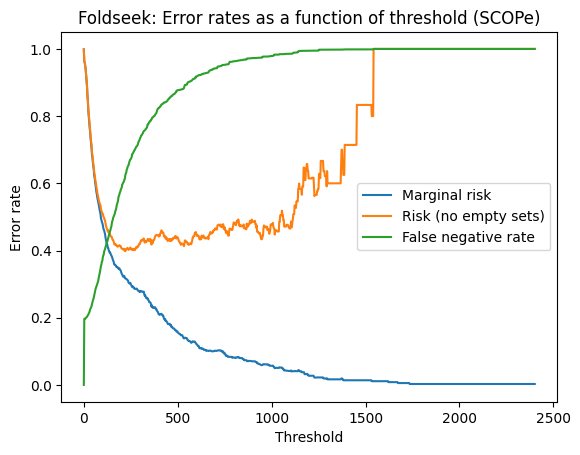

In [11]:
# Plot FDR + FNR as a function of lambda
plt.figure()
plt.plot(lambdas, risks, label='Marginal risk')
plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
plt.xlabel('Threshold')
plt.ylabel('Error rate')
plt.title('Foldseek: Error rates as a function of threshold (SCOPe)')
plt.legend()
plt.show()

## LTT, FNR

In [3]:
data[3]['S_i']

array([350, 257, 198, ...,   0,   0,   0])

In [12]:
num_trials = 100
alpha = 0.1 ## 10% FNR rate (exact)
n_calib = 350 # NOTE: 380 calib, 20 test for DALI prefiltering calibration.

lmbs = []
errors = []
partial_errors = []
fprs = []

for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:]

    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    _, y_test_partial = get_sims_labels(test_data, partial=True)
    lhat = get_thresh_new(X_cal, y_cal, alpha)

    lmbs.append(lhat)

    error, fraction_inexact, error_partial, fraction_partial, fpr = validate_lhat_new(X_test, y_test_partial, y_test_exact, lhat)
    errors.append(error)
    partial_errors.append(error_partial)
    fprs.append(fpr)

    print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}, FPR&Id/Id: {fpr:.2f}')

# mean and std of lambda
avg_lhat = np.mean(lmbs)
std_lhat = np.std(lmbs)
print(f'Mean exact lambda: {avg_lhat:.8f}, Std lambda: {std_lhat:.8f}')

Trial 1: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.00, FPR&Id/Id: 1.00
Trial 2: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.00, FPR&Id/Id: 1.00
Trial 3: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.00, FPR&Id/Id: 1.00
Trial 4: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.00, FPR&Id/Id: 1.00
Trial 5: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.01, FPR&Id/Id: 1.00
Trial 6: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.01, FPR&Id/Id: 1.00
Trial 7: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.00, FPR&Id/Id: 1.00
Trial 8: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.01, FPR&Id/Id: 1.00
Trial 9: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.00, FPR&Id/Id: 1.00
Trial 10: lhat: 0, Ex&!Id/Ex: 0.00, In/Id: 1.00, Pa&!Id/Pa: 0.00, Pa&Id/Id: 0.00, FPR&Id/Id: 1.00
Trial 11: lhat: 0, Ex&!Id/Ex: